In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import json
import glob
import os
from joblib import Parallel, delayed
warnings.filterwarnings("ignore")
os.environ['KMP_DUPLICATE_LIB_OK']='True'

labels_breed = pd.read_csv('./breed_labels.csv')
labels_colors = pd.read_csv('./color_labels.csv')
labels_states = pd.read_csv('./state_labels.csv')

train = pd.read_csv('./train.csv')
train_size = train.shape[0]
test = pd.read_csv('./test/test.csv')
test_size = test.shape[0]


data_all = pd.concat([train, test])
data_all.head()

,AdoptionSpeed,Age,Breed1,Breed2,Color1,Color2,Color3,Description,Dewormed,Fee,...,Name,PetID,PhotoAmt,Quantity,RescuerID,State,Sterilized,Type,Vaccinated,VideoAmt
0,2.0,3,299,0,1,7,0,Nibble is a 3+ month old ball of cuteness. He ...,2,100,...,Nibble,86e1089a3,1.0,1,8480853f516546f6cf33aa88cd76c379,41326,2,2,2,0
1,0.0,1,265,0,1,2,0,I just found it alone yesterday near my apartm...,3,0,...,No Name Yet,6296e909a,2.0,1,3082c7125d8fb66f7dd4bff4192c8b14,41401,3,2,3,0
2,3.0,1,307,0,2,7,0,Their pregnant mother was dumped by her irresp...,1,0,...,Brisco,3422e4906,7.0,1,fa90fa5b1ee11c86938398b60abc32cb,41326,2,1,1,0
3,2.0,4,307,0,1,2,0,"Good guard dog, very alert, active, obedience ...",1,150,...,Miko,5842f1ff5,8.0,1,9238e4f44c71a75282e62f7136c6b240,41401,2,1,1,0
4,2.0,1,307,0,1,0,0,This handsome yet cute boy is up for adoption....,2,0,...,Hunter,850a43f90,3.0,1,95481e953f8aed9ec3d16fc4509537e8,41326,2,1,2,0


In [2]:
data_all.columns
data_all_temp = data_all[['AdoptionSpeed', 'PetID', 'Age', 'Name', 'Vaccinated', 'Fee']]
data_all_temp.iloc[:2,:]

,AdoptionSpeed,PetID,Age,Name,Vaccinated,Fee
0,2.0,86e1089a3,3,Nibble,2,100
1,0.0,6296e909a,1,No Name Yet,3,0


In [3]:
train_image_files = sorted(glob.glob('./train_images/*.jpg'))
train_metadata_files = sorted(glob.glob('./train_metadata/*.json'))
train_sentiment_files = sorted(glob.glob('./train_sentiment/*.json'))

print('num of train images files: {}'.format(len(train_image_files)))
print('num of train metadata files: {}'.format(len(train_metadata_files)))
print('num of train sentiment files: {}'.format(len(train_sentiment_files)))


test_image_files = sorted(glob.glob('./test_images/*.jpg'))
test_metadata_files = sorted(glob.glob('./test_metadata/*.json'))
test_sentiment_files = sorted(glob.glob('./test_sentiment/*.json'))

print('num of test images files: {}'.format(len(test_image_files)))
print('num of test metadata files: {}'.format(len(test_metadata_files)))
print('num of test sentiment files: {}'.format(len(test_sentiment_files)))

num of train images files: 58311
num of train metadata files: 58311
num of train sentiment files: 14442
num of test images files: 15040
num of test metadata files: 15040
num of test sentiment files: 3815


In [4]:
data_all.info()
print(train.shape)
print(test.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18941 entries, 0 to 3947
Data columns (total 24 columns):
AdoptionSpeed    14993 non-null float64
Age              18941 non-null int64
Breed1           18941 non-null int64
Breed2           18941 non-null int64
Color1           18941 non-null int64
Color2           18941 non-null int64
Color3           18941 non-null int64
Description      18927 non-null object
Dewormed         18941 non-null int64
Fee              18941 non-null int64
FurLength        18941 non-null int64
Gender           18941 non-null int64
Health           18941 non-null int64
MaturitySize     18941 non-null int64
Name             17381 non-null object
PetID            18941 non-null object
PhotoAmt         18941 non-null float64
Quantity         18941 non-null int64
RescuerID        18941 non-null object
State            18941 non-null int64
Sterilized       18941 non-null int64
Type             18941 non-null int64
Vaccinated       18941 non-null int64
VideoAmt  

In [5]:
## train_data
train_df_ids = train[['PetID']]

# Images:
train_df_imgs = pd.DataFrame(train_image_files)
train_df_imgs.columns = ['image_filename']
train_imgs_pets = train_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_imgs['PetID'] = train_imgs_pets
print(len(train_imgs_pets.unique()))
print('fraction of pets with images: {}'.format(len(train_imgs_pets.unique()) / train_df_ids.shape[0]))

# Metadata:
train_df_metadata = pd.DataFrame(train_metadata_files)
train_df_metadata.columns = ['metadata_filename']
train_metadata_pets = train_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
train_df_metadata['PetID'] = train_metadata_pets
print(len(train_metadata_pets.unique()))
print('fraction of pets with metadata: {}'.format(len(train_metadata_pets.unique()) / train_df_ids.shape[0]))


# Sentiment:
train_df_sentiment = pd.DataFrame(train_sentiment_files)
train_df_sentiment.columns = ['sentiment_filename']
train_sentiment_pets = train_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
train_df_sentiment['PetID'] = train_sentiment_pets
print(len(train_sentiment_pets.unique()))
print('fraction of pets with sentiment: {}'.format(len(train_sentiment_pets.unique()) / train_df_ids.shape[0]))


## test data

test_df_ids = test[['PetID']]
print(test_df_ids.shape)

# Images:
test_df_imgs = pd.DataFrame(test_image_files)
test_df_imgs.columns = ['image_filename']
test_imgs_pets = test_df_imgs['image_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_imgs['PetID'] = test_imgs_pets
print(len(test_imgs_pets.unique()))
print('fraction of pets with images: {}'.format(len(test_imgs_pets.unique()) / test_df_ids.shape[0]))


# Metadata:
test_df_ids = test[['PetID']]
test_df_metadata = pd.DataFrame(test_metadata_files)
test_df_metadata.columns = ['metadata_filename']
test_metadata_pets = test_df_metadata['metadata_filename'].apply(lambda x: x.split('/')[-1].split('-')[0])
test_df_metadata['PetID'] = test_metadata_pets
print(len(test_metadata_pets.unique()))
print('fraction of pets with metadata: {}'.format(len(test_metadata_pets.unique()) / test_df_ids.shape[0]))



# Sentiment:
test_df_ids = test[['PetID']]
test_df_sentiment = pd.DataFrame(test_sentiment_files)
test_df_sentiment.columns = ['sentiment_filename']
test_sentiment_pets = test_df_sentiment['sentiment_filename'].apply(lambda x: x.split('/')[-1].split('.')[0])
test_df_sentiment['PetID'] = test_metadata_pets
print(len(test_sentiment_pets.unique()))
print('fraction of pets with sentiment: {}'.format(len(test_sentiment_pets.unique()) / test_df_ids.shape[0]))


14652
fraction of pets with images: 0.9772560528246516
14652
fraction of pets with metadata: 0.9772560528246516
14442
fraction of pets with sentiment: 0.9632495164410058
(3948, 1)
3821
fraction of pets with images: 0.9678318135764944
3821
fraction of pets with metadata: 0.9678318135764944
3815
fraction of pets with sentiment: 0.9663120567375887


In [6]:
class PetFinderParser(object):
    
    def __init__(self, debug=False):
        
        self.debug = debug
        self.sentence_sep = ' '
        
        # Does not have to be extracted because main DF already contains description
        self.extract_sentiment_text = False
        
        
    def open_metadata_file(self, filename):
        """
        Load metadata file.
        """
        with open(filename, 'r') as f:
            metadata_file = json.load(f)
        return metadata_file
            
    def open_sentiment_file(self, filename):
        """
        Load sentiment file.
        """
        with open(filename, 'r') as f:
            sentiment_file = json.load(f)
        return sentiment_file
            
    def open_image_file(self, filename):
        """
        Load image file.
        """
        image = np.asarray(Image.open(filename))
        return image
        
    def parse_sentiment_file(self, file):
        """
        Parse sentiment file. Output DF with sentiment features.
        """
        
        file_sentiment = file['documentSentiment']
        file_entities = [x['name'] for x in file['entities']]
        file_entities = self.sentence_sep.join(file_entities)

        if self.extract_sentiment_text:
            file_sentences_text = [x['text']['content'] for x in file['sentences']]
            file_sentences_text = self.sentence_sep.join(file_sentences_text)
        file_sentences_sentiment = [x['sentiment'] for x in file['sentences']]
        
        file_sentences_sentiment = pd.DataFrame.from_dict(
            file_sentences_sentiment, orient='columns').sum()
        file_sentences_sentiment = file_sentences_sentiment.add_prefix('document_').to_dict()
        
        file_sentiment.update(file_sentences_sentiment)
        
        df_sentiment = pd.DataFrame.from_dict(file_sentiment, orient='index').T
        if self.extract_sentiment_text:
            df_sentiment['text'] = file_sentences_text
            
        df_sentiment['entities'] = file_entities
        df_sentiment = df_sentiment.add_prefix('sentiment_')
        
        return df_sentiment
    
    def parse_metadata_file(self, file):
        """
        Parse metadata file. Output DF with metadata features.
        """
        
        file_keys = list(file.keys())
        
        if 'labelAnnotations' in file_keys:
            file_annots = file['labelAnnotations'][:int(len(file['labelAnnotations']) * 0.3)]
            file_top_score = np.asarray([x['score'] for x in file_annots]).mean()
            file_top_desc = [x['description'] for x in file_annots]
        else:
            file_top_score = np.nan
            file_top_desc = ['']
        
        file_colors = file['imagePropertiesAnnotation']['dominantColors']['colors']
        file_crops = file['cropHintsAnnotation']['cropHints']

        file_color_score = np.asarray([x['score'] for x in file_colors]).mean()
        file_color_pixelfrac = np.asarray([x['pixelFraction'] for x in file_colors]).mean()

        file_crop_conf = np.asarray([x['confidence'] for x in file_crops]).mean()
        
        if 'importanceFraction' in file_crops[0].keys():
            file_crop_importance = np.asarray([x['importanceFraction'] for x in file_crops]).mean()
        else:
            file_crop_importance = np.nan

        df_metadata = {
            'annots_score': file_top_score,
            'color_score': file_color_score,
            'color_pixelfrac': file_color_pixelfrac,
            'crop_conf': file_crop_conf,
            'crop_importance': file_crop_importance,
            'annots_top_desc': self.sentence_sep.join(file_top_desc)
        }
        
        df_metadata = pd.DataFrame.from_dict(df_metadata, orient='index').T
        df_metadata = df_metadata.add_prefix('metadata_')
        
        return df_metadata
    

# Helper function for parallel data processing:
def extract_additional_features(pet_id, mode='train'):
    
    sentiment_filename = './{}_sentiment/{}.json'.format(mode, pet_id)
    try:
        sentiment_file = pet_parser.open_sentiment_file(sentiment_filename)
        df_sentiment = pet_parser.parse_sentiment_file(sentiment_file)
        df_sentiment['PetID'] = pet_id
    except FileNotFoundError:
        df_sentiment = []

    dfs_metadata = []
    metadata_filenames = sorted(glob.glob('./{}_metadata/{}*.json'.format(mode, pet_id)))
    if len(metadata_filenames) > 0:
        for f in metadata_filenames:
            metadata_file = pet_parser.open_metadata_file(f)
            df_metadata = pet_parser.parse_metadata_file(metadata_file)
            df_metadata['PetID'] = pet_id
            dfs_metadata.append(df_metadata)
        dfs_metadata = pd.concat(dfs_metadata, ignore_index=True, sort=False)
    dfs = [df_sentiment, dfs_metadata]
    
    return dfs


pet_parser = PetFinderParser()

In [7]:
file = pet_parser.open_sentiment_file('./train_sentiment/0a0e8c15b.json')
file_entities = [x['name'] for x in file['entities']]
file_entities = ' '.join(file_entities)
file_entities

'Fenny market Old Klang Rd home Lai of Paws Mission breed mongrel companion children couple Dalmation adoption details noise'

In [8]:
# Unique IDs from train and test:
debug = False
train_pet_ids = train.PetID.unique()
test_pet_ids = test.PetID.unique()

if debug:
    train_pet_ids = train_pet_ids[:1000]
    test_pet_ids = test_pet_ids[:500]


In [9]:
# Train set:
# Parallel processing of data:
# dfs_train = (extract_additional_features(i, mode='train') for i in train_pet_ids)
dfs_train = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='train') for i in train_pet_ids)

# Extract processed data and format them as DFs:
train_dfs_sentiment = [x[0] for x in dfs_train if isinstance(x[0], pd.DataFrame)]
train_dfs_metadata = [x[1] for x in dfs_train if isinstance(x[1], pd.DataFrame)]

train_dfs_sentiment = pd.concat(train_dfs_sentiment, ignore_index=True, sort=False)
train_dfs_metadata = pd.concat(train_dfs_metadata, ignore_index=True, sort=False)

print(train_dfs_sentiment.shape, train_dfs_metadata.shape)


# Test set:
# Parallel processing of data:
dfs_test = Parallel(n_jobs=6, verbose=1)(
    delayed(extract_additional_features)(i, mode='test') for i in test_pet_ids)

# Extract processed data and format them as DFs:
test_dfs_sentiment = [x[0] for x in dfs_test if isinstance(x[0], pd.DataFrame)]
test_dfs_metadata = [x[1] for x in dfs_test if isinstance(x[1], pd.DataFrame)]

test_dfs_sentiment = pd.concat(test_dfs_sentiment, ignore_index=True, sort=False)
test_dfs_metadata = pd.concat(test_dfs_metadata, ignore_index=True, sort=False)

print(test_dfs_sentiment.shape, test_dfs_metadata.shape)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    5.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   11.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   19.6s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   30.4s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:   43.7s
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  1.3min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed:  2.1min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 7188 tasks      | elapsed:  3.1min
[Parallel(n_jobs=6)]: Done 8438 tasks      | elapsed:  3.7min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed:  4.9mi

(14442, 6) (58311, 7)


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 172 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 1372 tasks      | elapsed:   12.9s
[Parallel(n_jobs=6)]: Done 3372 tasks      | elapsed:   30.6s
[Parallel(n_jobs=6)]: Done 3948 out of 3948 | elapsed:   35.4s finished


(3815, 6) (15040, 7)


In [10]:
dfs_train[0][0]

,sentiment_magnitude,sentiment_score,sentiment_document_magnitude,sentiment_document_score,sentiment_entities,PetID
0,2.4,0.3,2.2,1.8,Nibble cuteness clinic cats result kitty coupl...,86e1089a3


In [11]:
dfs_train[0][1]

,metadata_annots_score,metadata_color_score,metadata_color_pixelfrac,metadata_crop_conf,metadata_crop_importance,metadata_annots_top_desc,PetID
0,0.973658,0.0748377,0.066331,0.8,1,cat black cat,86e1089a3


In [12]:
# Extend aggregates and improve column naming
aggregates = ['mean', 'sum']


# Train
train_metadata_desc = train_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
train_metadata_desc = train_metadata_desc.reset_index()
train_metadata_desc[
    'metadata_annots_top_desc'] = train_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
train_metadata_gr = train_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in train_metadata_gr.columns:
    if 'PetID' not in i:
        train_metadata_gr[i] = train_metadata_gr[i].astype(float)
train_metadata_gr = train_metadata_gr.groupby(['PetID']).agg(aggregates)
train_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_metadata_gr.columns.tolist()])
train_metadata_gr = train_metadata_gr.reset_index()


train_sentiment_desc = train_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
train_sentiment_desc = train_sentiment_desc.reset_index()
train_sentiment_desc[
    'sentiment_entities'] = train_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
train_sentiment_gr = train_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in train_sentiment_gr.columns:
    if 'PetID' not in i:
        train_sentiment_gr[i] = train_sentiment_gr[i].astype(float)
train_sentiment_gr = train_sentiment_gr.groupby(['PetID']).agg(aggregates)
train_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in train_sentiment_gr.columns.tolist()])
train_sentiment_gr = train_sentiment_gr.reset_index()


# Test
test_metadata_desc = test_dfs_metadata.groupby(['PetID'])['metadata_annots_top_desc'].unique()
test_metadata_desc = test_metadata_desc.reset_index()
test_metadata_desc[
    'metadata_annots_top_desc'] = test_metadata_desc[
    'metadata_annots_top_desc'].apply(lambda x: ' '.join(x))

prefix = 'metadata'
test_metadata_gr = test_dfs_metadata.drop(['metadata_annots_top_desc'], axis=1)
for i in test_metadata_gr.columns:
    if 'PetID' not in i:
        test_metadata_gr[i] = test_metadata_gr[i].astype(float)
test_metadata_gr = test_metadata_gr.groupby(['PetID']).agg(aggregates)
test_metadata_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_metadata_gr.columns.tolist()])
test_metadata_gr = test_metadata_gr.reset_index()


test_sentiment_desc = test_dfs_sentiment.groupby(['PetID'])['sentiment_entities'].unique()
test_sentiment_desc = test_sentiment_desc.reset_index()
test_sentiment_desc[
    'sentiment_entities'] = test_sentiment_desc[
    'sentiment_entities'].apply(lambda x: ' '.join(x))

prefix = 'sentiment'
test_sentiment_gr = test_dfs_sentiment.drop(['sentiment_entities'], axis=1)
for i in test_sentiment_gr.columns:
    if 'PetID' not in i:
        test_sentiment_gr[i] = test_sentiment_gr[i].astype(float)
test_sentiment_gr = test_sentiment_gr.groupby(['PetID']).agg(aggregates)
test_sentiment_gr.columns = pd.Index(['{}_{}_{}'.format(
            prefix, c[0], c[1].upper()) for c in test_sentiment_gr.columns.tolist()])
test_sentiment_gr = test_sentiment_gr.reset_index()

In [13]:
# Train merges:
train_proc = train.copy()
train_proc = train_proc.merge(
    train_sentiment_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_gr, how='left', on='PetID')
train_proc = train_proc.merge(
    train_metadata_desc, how='left', on='PetID')
train_proc = train_proc.merge(
    train_sentiment_desc, how='left', on='PetID')

# Test merges:
test_proc = test.copy()
test_proc = test_proc.merge(
    test_sentiment_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_gr, how='left', on='PetID')
test_proc = test_proc.merge(
    test_metadata_desc, how='left', on='PetID')
test_proc = test_proc.merge(
    test_sentiment_desc, how='left', on='PetID')


print(train_proc.shape, test_proc.shape)
assert train_proc.shape[0] == train.shape[0]
assert test_proc.shape[0] == test.shape[0]

(14993, 44) (3948, 43)


In [14]:
train_breed_main = train_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

train_breed_main = train_breed_main.iloc[:, 2:]
train_breed_main = train_breed_main.add_prefix('main_breed_')

train_breed_second = train_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

train_breed_second = train_breed_second.iloc[:, 2:]
train_breed_second = train_breed_second.add_prefix('second_breed_')


train_proc = pd.concat(
    [train_proc, train_breed_main, train_breed_second], axis=1)


test_breed_main = test_proc[['Breed1']].merge(
    labels_breed, how='left',
    left_on='Breed1', right_on='BreedID',
    suffixes=('', '_main_breed'))

test_breed_main = test_breed_main.iloc[:, 2:]
test_breed_main = test_breed_main.add_prefix('main_breed_')

test_breed_second = test_proc[['Breed2']].merge(
    labels_breed, how='left',
    left_on='Breed2', right_on='BreedID',
    suffixes=('', '_second_breed'))

test_breed_second = test_breed_second.iloc[:, 2:]
test_breed_second = test_breed_second.add_prefix('second_breed_')


test_proc = pd.concat(
    [test_proc, test_breed_main, test_breed_second], axis=1)

print(train_proc.shape, test_proc.shape)

(14993, 48) (3948, 47)


In [15]:
X = pd.concat([train_proc, test_proc], ignore_index=True, sort=False)
# Copy original X DF for easier experimentation,
# all feature engineering will be performed on this one:
X_temp = X.copy()


# Select subsets of columns:
text_columns = ['Description', 'metadata_annots_top_desc', 'sentiment_entities']
categorical_columns = ['main_breed_BreedName', 'second_breed_BreedName']

# Names are all unique, so they can be dropped by default
# Same goes for PetID, it shouldn't be used as a feature
to_drop_columns = ['PetID', 'Name', 'RescuerID']
# RescuerID will also be dropped, as a feature based on this column will be extracted independently

In [16]:
# Count RescuerID occurrences:
rescuer_count = X.groupby(['RescuerID'])['PetID'].count().reset_index()
rescuer_count.columns = ['RescuerID', 'RescuerID_COUNT']

# Merge as another feature onto main DF:
X_temp = X_temp.merge(rescuer_count, how='left', on='RescuerID')


In [17]:
# Factorize categorical columns:
for i in categorical_columns:
    X_temp.loc[:, i] = pd.factorize(X_temp.loc[:, i])[0]
    
# Subset text features:
X_text = X_temp[text_columns]

for i in X_text.columns:
    X_text.loc[:, i] = X_text.loc[:, i].fillna('<MISSING>')

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA, TruncatedSVD, LatentDirichletAllocation, NMF

n_components = 5
text_features = []


# Generate text features:
for i in X_text.columns:
    
    # Initialize decomposition methods:
    print('generating features from: {}'.format(i))
    svd_ = TruncatedSVD(
        n_components=n_components, random_state=1337)
    nmf_ = NMF(
        n_components=n_components, random_state=1337)
    
    tfidf_col = TfidfVectorizer().fit_transform(X_text.loc[:, i].values)
    svd_col = svd_.fit_transform(tfidf_col)
    svd_col = pd.DataFrame(svd_col)
    svd_col = svd_col.add_prefix('SVD_{}_'.format(i))
    
    nmf_col = nmf_.fit_transform(tfidf_col)
    nmf_col = pd.DataFrame(nmf_col)
    nmf_col = nmf_col.add_prefix('NMF_{}_'.format(i))
    
    text_features.append(svd_col)
    text_features.append(nmf_col)

    
# Combine all extracted features:
text_features = pd.concat(text_features, axis=1)

# Concatenate with main DF:
X_temp = pd.concat([X_temp, text_features], axis=1)

# Remove raw text columns:
for i in X_text.columns:
    X_temp = X_temp.drop(i, axis=1)

generating features from: Description
generating features from: metadata_annots_top_desc
generating features from: sentiment_entities


In [19]:
# Remove unnecessary columns:
X_temp = X_temp.drop(to_drop_columns, axis=1)

# Check final df shape:
print('X shape: {}'.format(X_temp.shape))

X shape: (18941, 73)


In [20]:
# Split into train and test again:
X_train = X_temp.loc[np.isfinite(X_temp.AdoptionSpeed), :]
X_test = X_temp.loc[~np.isfinite(X_temp.AdoptionSpeed), :]

# Remove missing target column from test:
X_test = X_test.drop(['AdoptionSpeed'], axis=1)


print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]


# Check if columns between the two DFs are the same:
train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

X_train shape: (14993, 73)
X_test shape: (3948, 72)


In [21]:
import scipy as sp

from collections import Counter
from functools import partial
from math import sqrt

from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.metrics import confusion_matrix as sk_cmatrix


# FROM: https://www.kaggle.com/myltykritik/simple-lgbm-image-features

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = quadratic_weighted_kappa(y, X_p)
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']
    
def rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))


In [22]:
import lightgbm as lgb

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'num_leaves': 70,
          'max_depth': 9,
          'learning_rate': 0.01,
          'bagging_fraction': 0.85,
          'feature_fraction': 0.8,
          'min_split_gain': 0.02,
          'min_child_samples': 150,
          'min_child_weight': 0.02,
          'lambda_l2': 0.0475,
          'verbosity': -1,
          'data_random_seed': 17}

# Additional parameters:
early_stop = 500
verbose_eval = 100
num_rounds = 10000
n_splits = 5

In [23]:
from sklearn.model_selection import StratifiedKFold


kfold = StratifiedKFold(n_splits=n_splits, random_state=1337)


oof_train = np.zeros((X_train.shape[0]))
oof_test = np.zeros((X_test.shape[0], n_splits))


i = 0
for train_index, valid_index in kfold.split(X_train, X_train['AdoptionSpeed'].values):
    
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    
    y_tr = X_tr['AdoptionSpeed'].values
    X_tr = X_tr.drop(['AdoptionSpeed'], axis=1)
    
    y_val = X_val['AdoptionSpeed'].values
    X_val = X_val.drop(['AdoptionSpeed'], axis=1)
    
    print('\ny_tr distribution: {}'.format(Counter(y_tr)))
    
    d_train = lgb.Dataset(X_tr, label=y_tr)
    d_valid = lgb.Dataset(X_val, label=y_val)
    watchlist = [d_train, d_valid]
    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)
    
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    oof_train[valid_index] = val_pred
    oof_test[:, i] = test_pred
    
    i += 1


y_tr distribution: Counter({4.0: 3357, 2.0: 3229, 3.0: 2607, 1.0: 2472, 0.0: 328})
training LGB:
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.05981	valid_1's rmse: 1.0949
[200]	training's rmse: 1.00942	valid_1's rmse: 1.06987
[300]	training's rmse: 0.976766	valid_1's rmse: 1.0598
[400]	training's rmse: 0.952989	valid_1's rmse: 1.0529
[500]	training's rmse: 0.933968	valid_1's rmse: 1.04875
[600]	training's rmse: 0.919382	valid_1's rmse: 1.0459
[700]	training's rmse: 0.903607	valid_1's rmse: 1.04333
[800]	training's rmse: 0.889744	valid_1's rmse: 1.04193
[900]	training's rmse: 0.878337	valid_1's rmse: 1.04101
[1000]	training's rmse: 0.867596	valid_1's rmse: 1.04
[1100]	training's rmse: 0.857199	valid_1's rmse: 1.03926
[1200]	training's rmse: 0.847319	valid_1's rmse: 1.0387
[1300]	training's rmse: 0.836784	valid_1's rmse: 1.03807
[1400]	training's rmse: 0.826728	valid_1's rmse: 1.03799
[1500]	training's rmse: 0.817824	valid_1's rmse: 1.03724
[16

(array([  19.,  225., 1341., 3096., 3607., 3060., 2174., 1118.,  332.,
          21.]),
 array([0.76368075, 1.12249949, 1.48131824, 1.84013698, 2.19895572,
        2.55777447, 2.91659321, 3.27541195, 3.6342307 , 3.99304944,
        4.35186818]),
 <a list of 10 Patch objects>)

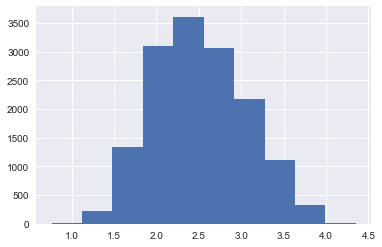

In [24]:
plt.hist(oof_train)

In [25]:
# Compute QWK based on OOF train predictions:
optR = OptimizedRounder()
optR.fit(oof_train, X_train['AdoptionSpeed'].values)
coefficients = optR.coefficients()
pred_test_y_k = optR.predict(oof_train, coefficients)
print("\nValid Counts = ", Counter(X_train['AdoptionSpeed'].values))
print("Predicted Counts = ", Counter(pred_test_y_k))
print("Coefficients = ", coefficients)
qwk = quadratic_weighted_kappa(X_train['AdoptionSpeed'].values, pred_test_y_k)
print("QWK = ", qwk)


Valid Counts =  Counter({4.0: 4197, 2.0: 4037, 3.0: 3259, 1.0: 3090, 0.0: 410})
Predicted Counts =  Counter({2.0: 3977, 4.0: 3793, 1.0: 3692, 3.0: 3531})
Coefficients =  [0.45737209 2.09710118 2.48984622 2.89432827]
QWK =  0.44252125082272553


In [26]:
train_predictions = optR.predict(oof_train, coefficients).astype(int)
print('train pred distribution: {}'.format(Counter(train_predictions)))

test_predictions = optR.predict(oof_test.mean(axis=1), coefficients)
print('test pred distribution: {}'.format(Counter(test_predictions)))

train pred distribution: Counter({2: 3977, 4: 3793, 1: 3692, 3: 3531})
test pred distribution: Counter({4.0: 1049, 2.0: 1018, 1.0: 958, 3.0: 923})


In [27]:
submission = pd.DataFrame({'PetID': test['PetID'].values, 'AdoptionSpeed': test_predictions.astype(np.int32)})
submission.head()
submission.to_csv('submission.csv', index=False)